In [273]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

from verstack import NaNImputer
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.model_selection import train_test_split

In [274]:
# Directory config to project root to insure consistency across environments for project specific imports
from pyprojroot import here
os.chdir(here())

# Project specific imports
from src.utils import save_dataframe


## Data Quering and Loading

In [275]:
# DB related imports
from database.db_utils import init_db
from config.config_loader import load_config
from database.queries import prepped_data_query
from sqlalchemy import text

# Initialize local PostgreSQL session
Session = init_db(load_config("DB_URL"))
session = Session()

# Execute and fetch results
data = session.execute(text(prepped_data_query))

# Close the DB session
session.close()

# Convert to DataFrame
data = pd.DataFrame(data.fetchall(), columns=data.keys())

# Saving cleaned dataset for future use
save_dataframe(data, "0_base_data.csv")

✅ Data successfully saved to ./data\0_base_data.csv with separator ','


In [276]:
# Load dataset
data = pd.read_csv("./data/0_base_data.csv")

data = data.dropna(subset=['genre_names'])

In [277]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7992 entries, 0 to 7992
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    7992 non-null   object 
 1   release_date             7992 non-null   object 
 2   tmdb_vote_count          7992 non-null   int64  
 3   tmdb_vote_average        7992 non-null   float64
 4   genre_names              7992 non-null   object 
 5   budget                   5386 non-null   float64
 6   revenue                  5863 non-null   float64
 7   runtime_in_min           7990 non-null   float64
 8   tmdb_popularity          7992 non-null   float64
 9   production_company_name  7963 non-null   object 
 10  production_country_name  7987 non-null   object 
 11  spoken_languages         7989 non-null   object 
 12  director                 7988 non-null   object 
 13  writer                   7933 non-null   object 
 14  actors                   7984

In [278]:
# Count missing values
data.isnull().sum()

title                         0
release_date                  0
tmdb_vote_count               0
tmdb_vote_average             0
genre_names                   0
budget                     2606
revenue                    2129
runtime_in_min                2
tmdb_popularity               0
production_company_name      29
production_country_name       5
spoken_languages              3
director                      4
writer                       59
actors                        8
imdb_rating                   9
imdb_votes                    7
metascore                  1833
age_rating                  497
awards                     1206
rotten_tomatoes_rating     1147
meta_critic_rating         1833
dtype: int64

## Exploration of missing data

I have gotten to know this data during the collection process but there are a few aspects I'd like to look into in more detail. Unfortunately, there seems to be quite a bit of missing data, especially in the `budget` and `revenue` columns which I intend to be my main prediction targets when training models. It is not a huge surprise, however, since companies tend to be quite guarded around the financial data of their projects. I will be looking into other sources of financial data in future.

Let's have a look at the total amount of missing data. Hopefully the blanks between the two interect.

In [279]:
# Assuming 'data' is your DataFrame
missing_budget_revenue_count = data[data['budget'].isna() & data['revenue'].isna()].shape[0]
missing_budget_count = data['budget'].isna().sum() - missing_budget_revenue_count
missing_revenue_count = data['revenue'].isna().sum() - missing_budget_revenue_count

# Calculate the total number of rows with missing values in either 'budget' or 'revenue'
total_missing_count = missing_budget_count + missing_revenue_count + missing_budget_revenue_count

print(f"- Number of rows where both budget and revenue are missing: {missing_budget_revenue_count}")
print(f"- Number of additional rows where budget is missing: {missing_budget_count}")
print(f"- Number of additional rows where revenue is missing: {missing_revenue_count}")
print(f"Total number of rows with missing values in either budget or revenue: {total_missing_count}")

- Number of rows where both budget and revenue are missing: 1667
- Number of additional rows where budget is missing: 939
- Number of additional rows where revenue is missing: 462
Total number of rows with missing values in either budget or revenue: 3068


There is indeed an unfortunate number of blanks. Most of them intersxect between the two columns but we still end up with about 30-35% of missing between the two so that is something I'll have to work around.

Let's have a look at the amount of rows missing financial data throughout time. I have a sneaking suspicion that it will be more common to not report financial data in more recent years.

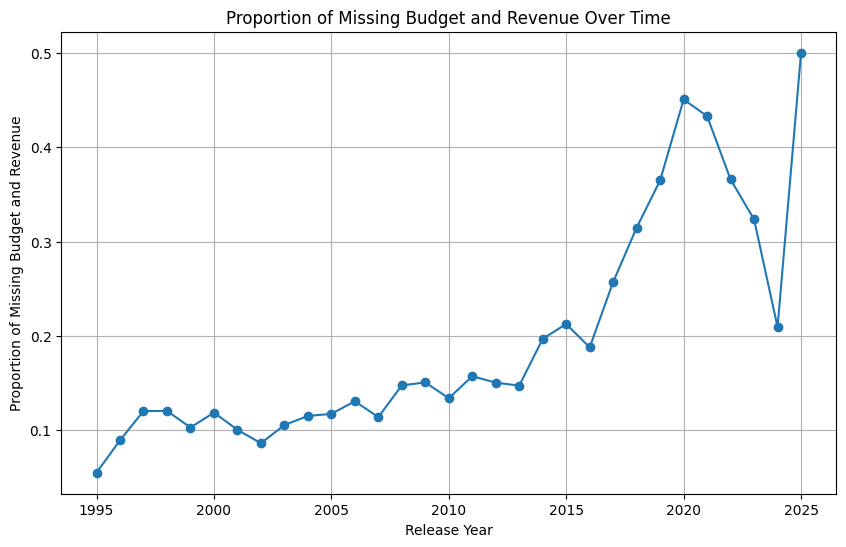

In [280]:
# Assuming 'data' is your DataFrame
plot_data = data.copy()
plot_data['release_date'] = pd.to_datetime(plot_data['release_date'])

# Create a new column to indicate if both budget and revenue are missing
plot_data['missing_budget_revenue'] = plot_data['budget'].isna() & plot_data['revenue'].isna()

# Group by release year and calculate the proportion of missing values
plot_data['release_year'] = plot_data['release_date'].dt.year
missing_by_year = plot_data.groupby('release_year')['missing_budget_revenue'].mean()

# Plot the proportion of missing values over time
plt.figure(figsize=(10, 6))
plt.plot(missing_by_year.index, missing_by_year.values, marker='o', linestyle='-')
plt.xlabel('Release Year')
plt.ylabel('Proportion of Missing Budget and Revenue')
plt.title('Proportion of Missing Budget and Revenue Over Time')
plt.grid(True)
plt.show()

I find it quite interesting that movie financial data has not been reported as frequently in recent years, especially around the COVID-19 pandemic. The movie industry has grown significantly, and so have the costs of producing films. Nowadays, blockbuster movies are often financed through external companies, making financial details a more sensitive topic. During the pandemic, the movie industry contracted, and the quality of movies declined. Consequently, movies have not been performing well financially of late, and companies like Disney may choose not to report this information to protect their stock value.

## Multilable Categorical Features

There are a nuymber of multilable categorical features that will need to be looked into.

In [281]:
def count_unique_values_for_feature(df: pd.DataFrame, feature: str, delimiter: str = ",") -> int:
    """
    Splits the specified feature column by the delimiter and returns the number of unique values.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        feature (str): The name of the column to process.
        delimiter (str): The delimiter used to separate multiple values in the column.

    Returns:
        int: The number of unique values.
    """
    return len(df[feature].dropna().str.split(rf"{delimiter}\s*").explode().unique())

# List of features you want to analyze:
features = [
    "genre_names", 
    "production_company_name", "production_country_name", 
            "spoken_languages", "director", "writer", "actors"]

# Create a dictionary with the counts for each feature:
unique_counts = {feature: count_unique_values_for_feature(data, feature) for feature in features}

# Display the results:
for feature, count in unique_counts.items():
    print(f"{feature}: {count} unique values")

genre_names: 19 unique values
production_company_name: 8782 unique values
production_country_name: 101 unique values
spoken_languages: 103 unique values
director: 3996 unique values
writer: 9464 unique values
actors: 9330 unique values


Some of these features contain thousands of unique values, making it impractical to encode them directly. A good approach is to analyze the distribution of observations per category and retain only the most frequent categories. The less frequent categories can be grouped into a single **"Other"** category. This method helps to reduce the dimensionality of the data while preserving the most significant information.

Let's take a look at the distributions per category:

In [282]:
def print_top_categories(df: pd.DataFrame, column: str, top_n: int, delimiter: str = ",", others_label: str = "Others") -> None:
    """
    Prints the top_n unique values from a multi-label column and the total count of values 
    that fall outside the top_n (which would be grouped as 'Others').

    Args:
        df (pd.DataFrame): The DataFrame containing your data.
        column (str): The name of the multi-label column.
        top_n (int): The number of top categories to display.
        delimiter (str): The delimiter separating multiple values (default is a comma).
        others_label (str): The label used for less frequent values.
    """
    # Split the column into individual values and count frequencies
    exploded = df[column].dropna().str.split(rf"{delimiter}\s*").explode().str.strip()
    counts = exploded.value_counts()
    
    # Get the top N categories and the sum for the rest
    top_categories = counts.head(top_n)
    others_count = counts[counts.index.difference(top_categories.index)].sum()
    
    print("--------------------------------------------------||")
    print(f"Top {top_n} unique values for '{column}':")
    print(top_categories)
    print(f"Total count of all other values (will be grouped as '{others_label}'): {others_count}")
    print("--------------------------------------------------||\n")


top_values = {
    "genre_names": 20,
    "production_company_name": 20,
    "production_country_name": 10,
    "spoken_languages": 10,
    "director": 20,
    "writer": 20,
    "actors": 20
}

for feature, top_n in top_values.items():
    print_top_categories(data, feature, top_n)

--------------------------------------------------||
Top 20 unique values for 'genre_names':
genre_names
Drama              3515
Comedy             2871
Thriller           2235
Action             1917
Adventure          1347
Romance            1306
Crime              1169
Horror             1166
Science Fiction     980
Family              934
Fantasy             915
Animation           783
Mystery             767
History             391
Music               227
War                 212
Documentary         130
TV Movie            104
Western              76
Name: count, dtype: int64
Total count of all other values (will be grouped as 'Others'): 0
--------------------------------------------------||

--------------------------------------------------||
Top 20 unique values for 'production_company_name':
production_company_name
Universal Pictures           394
Warner Bros. Pictures        362
Columbia Pictures            328
Paramount Pictures           267
20th Century Fox             242


- `genre_names`: Will be kept as is since the number of unique categories is perfectly manageable.
- `production_company_name`: Has a relatively even distribution, making it more useful for specific company investigations rather than model training. Therefore, it will be discarded for model training.
- `production_country_name`: Most values are concentrated in the US and the UK, making it a great candidate for consolidating less frequent categories into an "Other" category.
- `spoken_languages`: Another candidate for consolidation, potentially grouping into the top 5 most common languages.
- `director`: Similar to `production_company_name`, it has a wide distribution and will be discarded for model training.

## Preprocessing Pipeline

For this project, I would like to make extensive use of the pipeline functionality in SciKit-Learn to re-familiarize myself with the tool. I will also be making use of `FunctionTransformer` to have custom steps be part of the final pipeline.

### NaNImputer from verstack

The `NaNImputer` from the `verstack` library is a tool designed to handle missing values in a DataFrame. It provides various strategies for imputing missing values, including simple statistical methods and more advanced techniques. It automates the entire process and makes decisions on its own about the best approach for each column.

Due to the nature of the data, each observation in columns like `budget`, `revenue`, and the various critic scores are very individual, and imputation strategies like **median** and **mean** will not be appropriate options. Therefore, I want to make use of machine learning algorithms. `NaNImputer` will make use of `IterativeImputer` for such values, making it a more robust option.

In [283]:
# Define a function to add missing indicators for certain columns.
def impute_data(df: pd.DataFrame, colums_to_exclude: list = None) -> pd.DataFrame:
    if colums_to_exclude:
        df = df.drop(columns=colums_to_exclude).copy()
    else:
        df.copy()
    imputer = NaNImputer()
    df = imputer.impute(df)
    return df

imputation_transformer = FunctionTransformer(impute_data, validate=False)

#### Data Types cionversion transformers

Some features need to be reformatted and below functions will deal with that.

In [284]:
# Some columns need to get converted to numeric
def convert_to_numeric(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for col in df.columns:
        # Convert to string, remove commas, then convert to numeric
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
    return df

to_numeric = FunctionTransformer(convert_to_numeric, validate=False)

#### Missing indicator features
I want to set up binary features for the columns where I have a large number of blanks to be able to investigate the imputed data later on.

In [285]:
# Define a function to add missing indicators for certain columns.
def add_missing_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for col in df.columns:
        df[col + "_missing"] = df[col].isnull().astype(int)
    return df

missing_indicator_transformer = FunctionTransformer(add_missing_indicators, validate=False)

# iter_cols = ['metascore', 'rotten_tomatoes_rating', 'meta_critic_rating', 'budget', 'revenue']

### Feature Engineering

#### Award features
The `awards` column can be used to extract various columns for BAFTAs, Oscars and total awards and nominations.

In [286]:
def extract_awards_info(awards_str):
    """
    Extracts numerical awards information from a text string.

    Parameters
    ----------
    awards_str : str
        The awards description string.

    Returns
    -------
    pd.Series
        A Series with the following index:
        ["total_wins", "total_noms", "oscar_wins", "oscar_noms", "bafta_wins", "bafta_noms"]
    """
    # Handle missing or "N/A" values.
    if pd.isna(awards_str) or awards_str.strip() in ["N/A", ""]:
        return pd.Series([0, 0, 0, 0, 0, 0],
                         index=["total_wins", "total_noms", "oscar_wins", "oscar_noms", "bafta_wins", "bafta_noms"])
    
    # Extract overall totals.
    # Look for a pattern like "56 wins" (we use negative lookahead to avoid picking up Oscar wins)
    total_wins_match = re.search(r'(\d+)\s+wins?(?!.*Oscars)', awards_str, flags=re.IGNORECASE)
    total_noms_match = re.search(r'(\d+)\s+nominations', awards_str, flags=re.IGNORECASE)
    total_wins = int(total_wins_match.group(1)) if total_wins_match else 0
    total_noms = int(total_noms_match.group(1)) if total_noms_match else 0

    # Oscar-specific extraction:
    oscar_noms_match = re.search(r'Nominated for\s+(\d+)\s+Oscars?', awards_str, flags=re.IGNORECASE)
    oscar_noms = int(oscar_noms_match.group(1)) if oscar_noms_match else 0
    # Look for something like "Oscars. 56 wins" or "Oscars 56 wins" (using non-digit separator)
    oscar_wins_match = re.search(r'Oscars?[\W_]+(\d+)\s+wins?', awards_str, flags=re.IGNORECASE)
    oscar_wins = int(oscar_wins_match.group(1)) if oscar_wins_match else 0

    # BAFTA-specific extraction:
    # For nominations, sometimes the text might run together (e.g. "BAFTA Award28 nominations total")
    bafta_noms_match = re.search(r'Nominated for\s+(\d+)\s*BAFTA', awards_str, flags=re.IGNORECASE)
    bafta_noms = int(bafta_noms_match.group(1)) if bafta_noms_match else 0
    # For wins, allow an optional "Award" word after BAFTA.
    bafta_wins_match = re.search(r'BAFTA(?:\s+Award)?[\D_]+(\d+)\s+wins?', awards_str, flags=re.IGNORECASE)
    bafta_wins = int(bafta_wins_match.group(1)) if bafta_wins_match else 0

    return pd.Series([total_wins, total_noms, oscar_wins, oscar_noms, bafta_wins, bafta_noms],
                     index=["total_wins", "total_noms", "oscar_wins", "oscar_noms", "bafta_wins", "bafta_noms"])


def transform_awards(X):
    """
    Expects X to be a DataFrame with a single column (e.g., 'awards').
    Applies extract_awards_info row-wise and returns a DataFrame.
    """
    # Apply the function to the first (and only) column
    return X.iloc[:, 0].apply(extract_awards_info)

# Wrap the function in a FunctionTransformer
awards_transformer = FunctionTransformer(transform_awards, validate=False)

#### Multi-lable categorical features adjustment

Below ``FunctionTransformer`` will group the given multi-lable feature into a top N + Others categories.

In [287]:
def transform_top_categories(X, column, top_n, delimiter=",", others_label="Others"):
    """
    Transforms a multi-label column by keeping only the top_n categories (based on frequency)
    and replacing all other categories with a generic label.
    
    Parameters:
        X (pd.DataFrame): Input DataFrame.
        column (str): The name of the multi-label column to process.
        top_n (int): Number of top categories to keep.
        delimiter (str): Delimiter separating the values.
        others_label (str): Label to assign to categories not among the top_n.
    
    Returns:
        pd.DataFrame: A DataFrame with one column (the processed column).
    """
    X = X.copy()
    # Split the column values, explode, and count frequencies.
    exploded = X[column].dropna().str.split(rf"{delimiter}\s*").explode().str.strip()
    counts = exploded.value_counts()
    top_categories = counts.head(top_n).index.tolist()
    
    def map_categories(cell):
        if pd.isna(cell):
            return cell
        # Split and strip each value.
        cats = [cat.strip() for cat in cell.split(delimiter)]
        # Replace values not in top_categories with others_label.
        new_cats = [cat if cat in top_categories else others_label for cat in cats]
        # Remove duplicates while preserving order.
        seen = set()
        new_cats = [x for x in new_cats if x not in seen and not seen.add(x)]
        return delimiter.join(new_cats)
    
    X[column] = X[column].apply(map_categories)
    # Return a DataFrame with just the transformed column.
    return X[[column]]

# Now, to create a FunctionTransformer for, say, the 'production_country_name' column with top_n=5:
transformer_prod_country = FunctionTransformer(
    func=partial(transform_top_categories, column="production_country_name", top_n=5, delimiter=",", others_label="Others"),
    validate=False
)

# Similarly, for 'spoken_languages' column with top_n=5:
transformer_spoken_lang = FunctionTransformer(
    func=partial(transform_top_categories, column="spoken_languages", top_n=5, delimiter=",", others_label="Others"),
    validate=False
)

#### Release date rework

`release_date` can be split int oseparate integer columns to be used during training later but binary features like `is_weekend` and `is_holiday` can also be derived.

In [288]:
def add_date_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month
    df['release_day'] = df['release_date'].dt.day
    df['is_weekend'] = (df['release_date'].dt.weekday >= 4).astype(int)
    df['is_holiday_season'] = df['release_month'].isin([6, 7, 11, 12]).astype(int)
    df['movie_age'] = 2025 - df['release_year']
    return df

# Wrap the function as a transformer
date_features_transformer = FunctionTransformer(add_date_features, validate=False)

#### Return on Investment
Great option for looking into the budget-revenue relationship

In [289]:
def calculate_roi(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['roi'] = (df['revenue'] - df['budget']) / df['budget']
    return df

# Wrap the function as a transformer
roi_transformer = FunctionTransformer(calculate_roi, validate=False)

#### `actors`, `directors` and `writers`

These features are quite valuable I think but they need to be reworked. I do know that IMDB has these ones ordered by importance and billing so we can get the most relevant people in each category.

In [290]:
def extract_actors(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['first_billing_actor'] = df['actors'].apply(lambda x: x.split(',')[0].strip() if pd.notnull(x) and len(x.split(',')) > 0 else None)
    df['second_billing_actor'] = df['actors'].apply(lambda x: x.split(',')[1].strip() if pd.notnull(x) and len(x.split(',')) > 1 else None)
    df['third_billing_actor'] = df['actors'].apply(lambda x: x.split(',')[2].strip() if pd.notnull(x) and len(x.split(',')) > 2 else None)
    return df.drop(columns=['actors'])

def extract_directors(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['main_director'] = df['director'].apply(lambda x: x.split(',')[0].strip() if pd.notnull(x) and len(x.split(',')) > 0 else None)
    df['secondary_director'] = df['director'].apply(lambda x: x.split(',')[1].strip() if pd.notnull(x) and len(x.split(',')) > 1 else None)
    return df.drop(columns=['director'])

def extract_writers(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['main_writer'] = df['writer'].apply(lambda x: x.split(',')[0].strip() if pd.notnull(x) and len(x.split(',')) > 0 else None)
    df['secondary_writer'] = df['writer'].apply(lambda x: x.split(',')[1].strip() if pd.notnull(x) and len(x.split(',')) > 1 else None)
    return df.drop(columns=['writer'])

# Create FunctionTransformers
actors_transformer = FunctionTransformer(extract_actors)
directors_transformer = FunctionTransformer(extract_directors)
writers_transformer = FunctionTransformer(extract_writers)

#### Dropper
Seetting up a dropper transformer that can be used in a pipeline

In [291]:
# Define a function transformer to drop unwanted columns.
def drop_unwanted_columns(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    return df.drop(columns=columns, errors='ignore')

columns_to_drop = ['production_company_name', 'director', 'writer', 'actors', 'title', 'release_date']

dropper = FunctionTransformer(drop_unwanted_columns, kw_args={'columns': columns_to_drop})

### Main ColumnTransformer
This `ColumnTransformer` will apply the included steps simultaniously. Each step relies on its own set of features so there is no overlap and no chance of issues. `Pipeline` applies the step in order which I will make use of later on.

In [292]:
main_transformer = ColumnTransformer(
    transformers=[
        ('missing_indicator', missing_indicator_transformer, ['metascore', 'rotten_tomatoes_rating', 'meta_critic_rating', 'budget', 'revenue']),
        ('awards', awards_transformer, ['awards']),
        ('date_feature_engineering', date_features_transformer, ['release_date']),
        ('top_n_prod_country', transformer_prod_country, ['production_country_name']),
        ('top_n_spoken_lang', transformer_spoken_lang, ['spoken_languages']),
        ('actors', actors_transformer, ['actors']),
        ('directors', directors_transformer, ['director']),
        ('writers', writers_transformer, ['writer']),
        ('to_numeric', to_numeric, ['imdb_rating', 'imdb_votes'])
    ],
    remainder='passthrough', 
    verbose_feature_names_out=False
)

# Set output to pandas dataframe
main_transformer.set_output(transform='pandas')

# Apply the preprocessor to the data
# clean_data = main_transformer.fit_transform(data)
# clean_data.head()

ColumnTransformer(remainder='passthrough',
                  transformers=[('missing_indicator',
                                 FunctionTransformer(func=<function add_missing_indicators at 0x000001ADA82B4FE0>),
                                 ['metascore', 'rotten_tomatoes_rating',
                                  'meta_critic_rating', 'budget', 'revenue']),
                                ('awards',
                                 FunctionTransformer(func=<function transform_awards at 0x000001ADA82B6AC0>),
                                 ['awards']),
                                ('date_feature_engi...
                                 ['actors']),
                                ('directors',
                                 FunctionTransformer(func=<function extract_directors at 0x000001ADA22BAD40>),
                                 ['director']),
                                ('writers',
                                 FunctionTransformer(func=<function extract_writers at 0x000001ADA22BB9C0>),
                                 ['writer']),
                                ('to_numeric',
                                 FunctionTransformer(func=<function convert_to_numeric at 0x000001ADA82B4860>),
                                 ['imdb_rating', 'imdb_votes'])],
                  verbose_feature_names_out=False)

In [293]:
clean_data = main_transformer.fit_transform(data)
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7992 entries, 0 to 7992
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   metascore                       6159 non-null   float64       
 1   rotten_tomatoes_rating          6845 non-null   float64       
 2   meta_critic_rating              6159 non-null   float64       
 3   budget                          5386 non-null   float64       
 4   revenue                         5863 non-null   float64       
 5   metascore_missing               7992 non-null   int64         
 6   rotten_tomatoes_rating_missing  7992 non-null   int64         
 7   meta_critic_rating_missing      7992 non-null   int64         
 8   budget_missing                  7992 non-null   int64         
 9   revenue_missing                 7992 non-null   int64         
 10  total_wins                      7992 non-null   int64         
 11  total_nom

### Pipeline

#### Full data pipeline

The main transformer will be applied so that all the feature transformations and engineering gets applied on actual data and then all the missing data will be imputed. I like this order because it makes sure the generated features are all based on real data. 

I would like to experiment a bit with various inputs of the imputation to study the effects on model performance and prediction. Let's start with running the imputation on all available data simultaniously.

In [294]:
# Setting up pipeline
imputation_pipeline = Pipeline(steps=[
    # ('main_transformer', main_transformer),
    ('impute_data', imputation_transformer),
    # ('roi_feature_engineering', roi_transformer),
    # ('dropper', dropper)
])

# Set output to pandas dataframe
imputation_pipeline.set_output(transform='pandas')

Pipeline(steps=[('impute_data',
                 FunctionTransformer(func=<function impute_data at 0x000001ADA82B7880>))])

In [295]:
imputed_data_full = imputation_pipeline.fit_transform(clean_data)


 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         7992
     .. columns:      42
     .. mb in memory: 2.5
     .. NaN cols num: 19

   - Drop hopeless NaN cols

   - droped column secondary_director with NaNs and a constant non-NaN value
     . Missing values in spoken_languages replaced by "Missing_data" string
     . Missing values in first_billing_actor replaced by "Missing_data" string
     . Missing values in second_billing_actor replaced by "Missing_data" string
     . Missing values in third_billing_actor replaced by "Missing_data" string
     . Missing values in main_director replaced by "Missing_data" string
     . Missing values in main_writer replaced by "Missing_data" string
     . Missing values in secondary_writer replaced by "Missing_data" string
     . Missing values in production_company_name replaced by "Missing_data" string

   - Processing whole data for imputation

   - Imputing single core 10 cols
     . Imputed (regression) - 1833 

In [296]:
imputed_data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7992 entries, 0 to 7992
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   metascore                       7992 non-null   float64       
 1   rotten_tomatoes_rating          7992 non-null   float64       
 2   meta_critic_rating              7992 non-null   float64       
 3   budget                          7992 non-null   float64       
 4   revenue                         7992 non-null   float64       
 5   metascore_missing               7992 non-null   int64         
 6   rotten_tomatoes_rating_missing  7992 non-null   int64         
 7   meta_critic_rating_missing      7992 non-null   int64         
 8   budget_missing                  7992 non-null   int64         
 9   revenue_missing                 7992 non-null   int64         
 10  total_wins                      7992 non-null   int64         
 11  total_nom

In [297]:
# Saving cleaned dataset for future use
save_dataframe(imputed_data_full, "1.1_imputed_data_full.csv")

✅ Data successfully saved to ./data\1.1_imputed_data_full.csv with separator ','


#### No Revenue Pipeline
Let's exclude the target of my predictive modelimg which will be `revenue` to make sure the model cannot gain any information due to the reelations created by the imputation.

In [298]:
imputed_data_no_revenue = imputation_pipeline.fit_transform(clean_data.drop(columns=['revenue', 'revenue_missing']))


 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         7992
     .. columns:      40
     .. mb in memory: 2.63
     .. NaN cols num: 18

   - Drop hopeless NaN cols

   - droped column secondary_director with NaNs and a constant non-NaN value
     . Missing values in spoken_languages replaced by "Missing_data" string
     . Missing values in first_billing_actor replaced by "Missing_data" string
     . Missing values in second_billing_actor replaced by "Missing_data" string
     . Missing values in third_billing_actor replaced by "Missing_data" string
     . Missing values in main_director replaced by "Missing_data" string
     . Missing values in main_writer replaced by "Missing_data" string
     . Missing values in secondary_writer replaced by "Missing_data" string
     . Missing values in production_company_name replaced by "Missing_data" string

   - Processing whole data for imputation

   - Imputing single core 9 cols
     . Imputed (regression) - 1833 

In [299]:
imputed_data_no_revenue['revenue'] = clean_data['revenue']
imputed_data_no_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7992 entries, 0 to 7992
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   metascore                       7992 non-null   float64       
 1   rotten_tomatoes_rating          7992 non-null   float64       
 2   meta_critic_rating              7992 non-null   float64       
 3   budget                          7992 non-null   float64       
 4   metascore_missing               7992 non-null   int64         
 5   rotten_tomatoes_rating_missing  7992 non-null   int64         
 6   meta_critic_rating_missing      7992 non-null   int64         
 7   budget_missing                  7992 non-null   int64         
 8   total_wins                      7992 non-null   int64         
 9   total_noms                      7992 non-null   int64         
 10  oscar_wins                      7992 non-null   int64         
 11  oscar_nom

In [300]:
# Saving cleaned dataset for future use
save_dataframe(imputed_data_no_revenue, "1.2_imputed_data_no_revenue.csv")

✅ Data successfully saved to ./data\1.2_imputed_data_no_revenue.csv with separator ','


### Split data Imputation

In [301]:
clean_data = clean_data.dropna(subset=['revenue'])

target = 'revenue'
X = clean_data.drop(columns=[target, 'revenue_missing'], axis=1)
y = clean_data[target]


In [302]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [303]:
split_pipeline = imputation_pipeline.fit(X, y)
X_train_imputed = split_pipeline.transform(X_train)
X_test_imputed = split_pipeline.transform(X_test)


 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         4983
     .. columns:      40
     .. mb in memory: 1.48
     .. NaN cols num: 16

   - Drop hopeless NaN cols

   - droped column secondary_director with NaNs and a constant non-NaN value
     . Missing values in first_billing_actor replaced by "Missing_data" string
     . Missing values in second_billing_actor replaced by "Missing_data" string
     . Missing values in third_billing_actor replaced by "Missing_data" string
     . Missing values in main_writer replaced by "Missing_data" string
     . Missing values in secondary_writer replaced by "Missing_data" string
     . Missing values in production_company_name replaced by "Missing_data" string

   - Processing whole data for imputation

   - Imputing single core 9 cols
     . Imputed (regression) - 548      NaN in metascore
     . Imputed (regression) - 376      NaN in rotten_tomatoes_rating
     . Imputed (regression) - 548      NaN in meta_critic_r

In [304]:
X_train_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4983 entries, 6797 to 1546
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   metascore                       4983 non-null   float64       
 1   rotten_tomatoes_rating          4983 non-null   float64       
 2   meta_critic_rating              4983 non-null   float64       
 3   budget                          4983 non-null   float64       
 4   metascore_missing               4983 non-null   int64         
 5   rotten_tomatoes_rating_missing  4983 non-null   int64         
 6   meta_critic_rating_missing      4983 non-null   int64         
 7   budget_missing                  4983 non-null   int64         
 8   total_wins                      4983 non-null   int64         
 9   total_noms                      4983 non-null   int64         
 10  oscar_wins                      4983 non-null   int64         
 11  oscar_

In [305]:
X_test_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 880 entries, 4015 to 213
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   metascore                       880 non-null    float64       
 1   rotten_tomatoes_rating          880 non-null    float64       
 2   meta_critic_rating              880 non-null    float64       
 3   budget                          880 non-null    float64       
 4   metascore_missing               880 non-null    int64         
 5   rotten_tomatoes_rating_missing  880 non-null    int64         
 6   meta_critic_rating_missing      880 non-null    int64         
 7   budget_missing                  880 non-null    int64         
 8   total_wins                      880 non-null    int64         
 9   total_noms                      880 non-null    int64         
 10  oscar_wins                      880 non-null    int64         
 11  oscar_no

In [306]:
# Saving cleaned dataset for future use
save_dataframe(X_train_imputed, "1.3.1_X_train_imputed.csv")
save_dataframe(X_test_imputed, "1.3.2_X_test_imputed.csv")
save_dataframe(y_train, "1.3.3_y_train.csv")
save_dataframe(y_test, "1.3.4_y_test.csv")

✅ Data successfully saved to ./data\1.3.1_X_train_imputed.csv with separator ','
✅ Data successfully saved to ./data\1.3.2_X_test_imputed.csv with separator ','
✅ Data successfully saved to ./data\1.3.3_y_train.csv with separator ','
✅ Data successfully saved to ./data\1.3.4_y_test.csv with separator ','
